# Design the bound states, sampling backbones for looping while maintaining sequence realism

### Imports

In [2]:
# %load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import dask
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /home/broerman/crispy_shifty/projects/OPS/round_1/design
running on node: sofia


### One-state design the helix-bound states

In [4]:
sys.path.insert(0, "/home/broerman/crispy_shifty")
from crispy_shifty.utils.io import gen_array_tasks

simulation_name = "03_design_bound_states"
design_list_file = "/home/broerman/crispy_shifty/projects/OPS/round_1/design/02_make_bound_states/bound_states.list"
output_path = os.path.join("/home/broerman/crispy_shifty/projects/OPS/round_1/design", simulation_name)
options = " ".join(
    [
        "out:level 200",
        "corrections::beta_nov16 true",
    ]
)

gen_array_tasks(
    distribute_func="crispy_shifty.protocols.design.one_state_design_bound_state",
    design_list_file=design_list_file,
    output_path=output_path,
    queue="medium",
    memory="3G",
    nstruct=10,
    nstruct_per_task=2,
    options=options,
    simulation_name=simulation_name,
)

Run the following command with your desired environment active:
sbatch -a 1-1740 /home/broerman/crispy_shifty/projects/OPS/round_1/design/03_design_bound_states/run.sh


### Collect scorefiles of the designed bound states and concatenate

In [3]:
sys.path.insert(0, "/home/broerman/crispy_shifty")
from crispy_shifty.utils.io import collect_score_file

simulation_name = "03_design_bound_states"
output_path = os.path.join("/home/broerman/crispy_shifty/projects/OPS/round_1/design", simulation_name)

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


### Load resulting concatenated scorefile

In [3]:
sys.path.insert(0, "/home/broerman/crispy_shifty")
from crispy_shifty.utils.io import parse_scorefile_linear

simulation_name = "03_design_bound_states"
output_path = os.path.join("/home/broerman/crispy_shifty/projects/OPS/round_1/design", simulation_name)

scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))
scores_df = scores_df.convert_dtypes()

  0%|          | 0/6940 [00:00<?, ?it/s]

### Data exploration
Gonna remove the Rosetta sfxn scoreterms for now

In [4]:
from crispy_shifty.protocols.design import beta_nov16_terms

scores_df = scores_df[
    [term for term in scores_df.columns if term not in beta_nov16_terms]
]
print(len(scores_df))
scores_df.columns

6940


Index(['bb_clash', 'buns_parent', 'cms_AcB', 'cms_AnAc', 'cms_AnAcB',
       'cms_AnB', 'docked_helix', 'exposed_hydrophobics_parent', 'fixed_resis',
       'geometry_parent', 'holes_all_parent', 'holes_core_parent', 'loop_dist',
       'mismatch_probability_parent', 'packstat_parent', 'parent',
       'parent_length', 'path_in', 'pdb', 'pivot_helix', 'pre_break_helix',
       'repeat_len', 'sap_parent', 'sc_AcB', 'sc_AnAc', 'sc_AnAcB', 'sc_AnB',
       'sc_all_parent', 'score', 'score_per_res', 'score_per_res_parent',
       'shift', 'ss_sc', 'state', 'time', 'topo', 'total_score', 'trim_n',
       'trimmed_length'],
      dtype='object')

### Convert some dtypes

In [5]:
scores_df["time"] = scores_df.time.astype(float) / 60
scores_df["bb_clash"] = scores_df.bb_clash.astype(float)
scores_df["trimmed_length"] = scores_df.trimmed_length.astype(int)

### Check for the relationship between time of run and length of parent

2it [00:00, 34.03it/s]


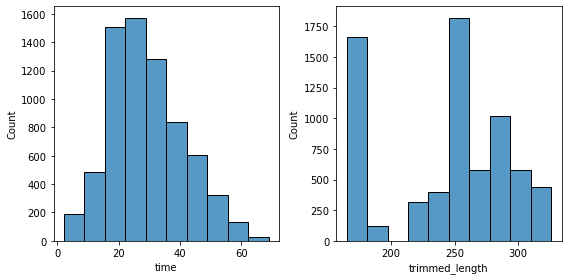

In [6]:
from crispy_shifty.utils.plotting import histplot_df, pairplot_df

cols = ["time", "trimmed_length"]

the_fig = histplot_df(
    df=scores_df,
    cols=cols,
    bins=10,
)

plt.savefig(os.path.join(output_path, "time_vs_length.png"))

<Figure size 576x576 with 0 Axes>

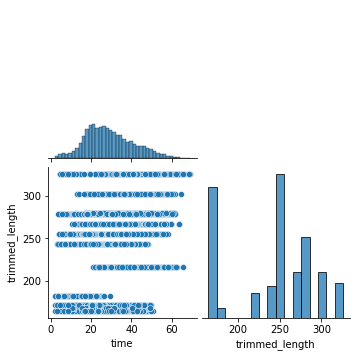

In [7]:
the_fig = pairplot_df(
    df=scores_df,
    cols=cols,
)

plt.savefig(os.path.join(output_path, "time_vs_length_paired.png"))

### Check for the relationship between time of run and `bb_clash` of input state

<Figure size 576x576 with 0 Axes>

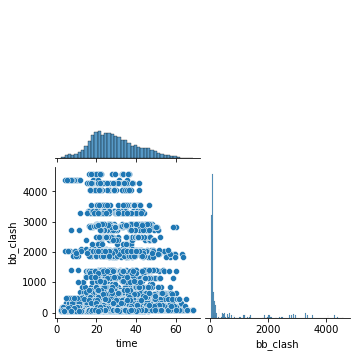

In [8]:
cols = ["time", "bb_clash"]

the_fig = pairplot_df(
    df=scores_df,
    cols=cols,
)

plt.savefig(os.path.join(output_path, "time_vs_bb_clash_paired.png"))

### Check the `ContactMolecularSurface` and `ShapeComplementarity`
Anything with `sc_*`< 0 doesn't have an interface at that site

6713


9it [00:00, 36.22it/s]


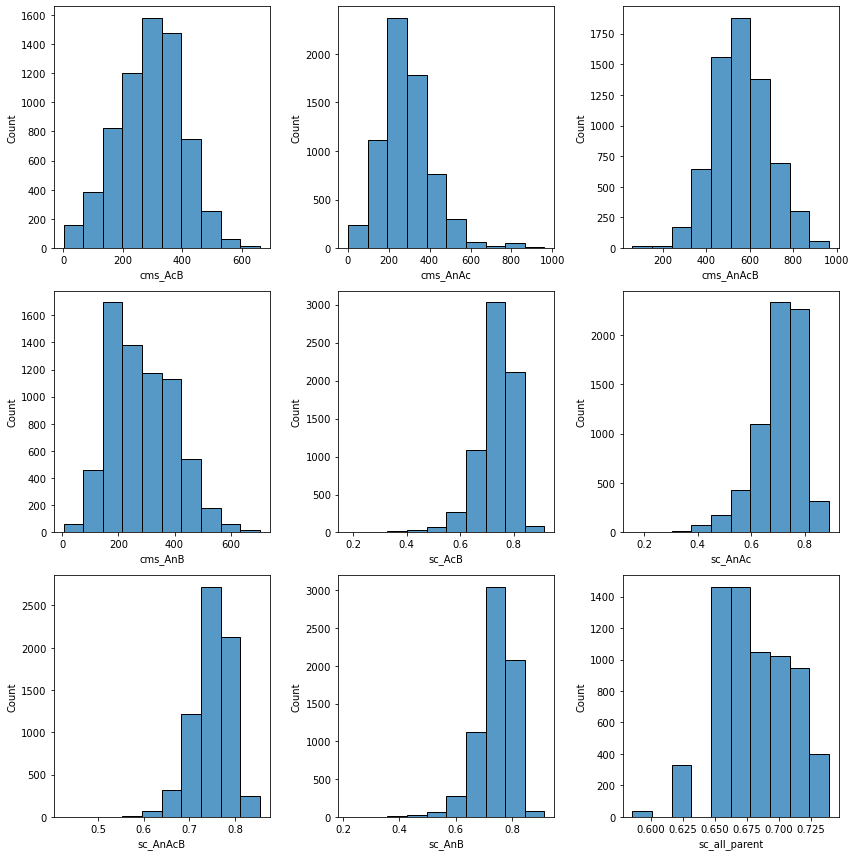

In [9]:
cols = [col for col in scores_df.columns if "cms_" in col or "sc_" in col]
for col in cols:
    scores_df[col] = scores_df[col].astype(float)

filt_df = scores_df
for col in cols:
    filt_df = filt_df[filt_df[col] > 0]
print(len(filt_df))
the_fig = histplot_df(df=filt_df, bins=10, cols=cols)
plt.savefig(os.path.join(output_path, "cms_and_sc.png"))

<Figure size 2592x2592 with 0 Axes>

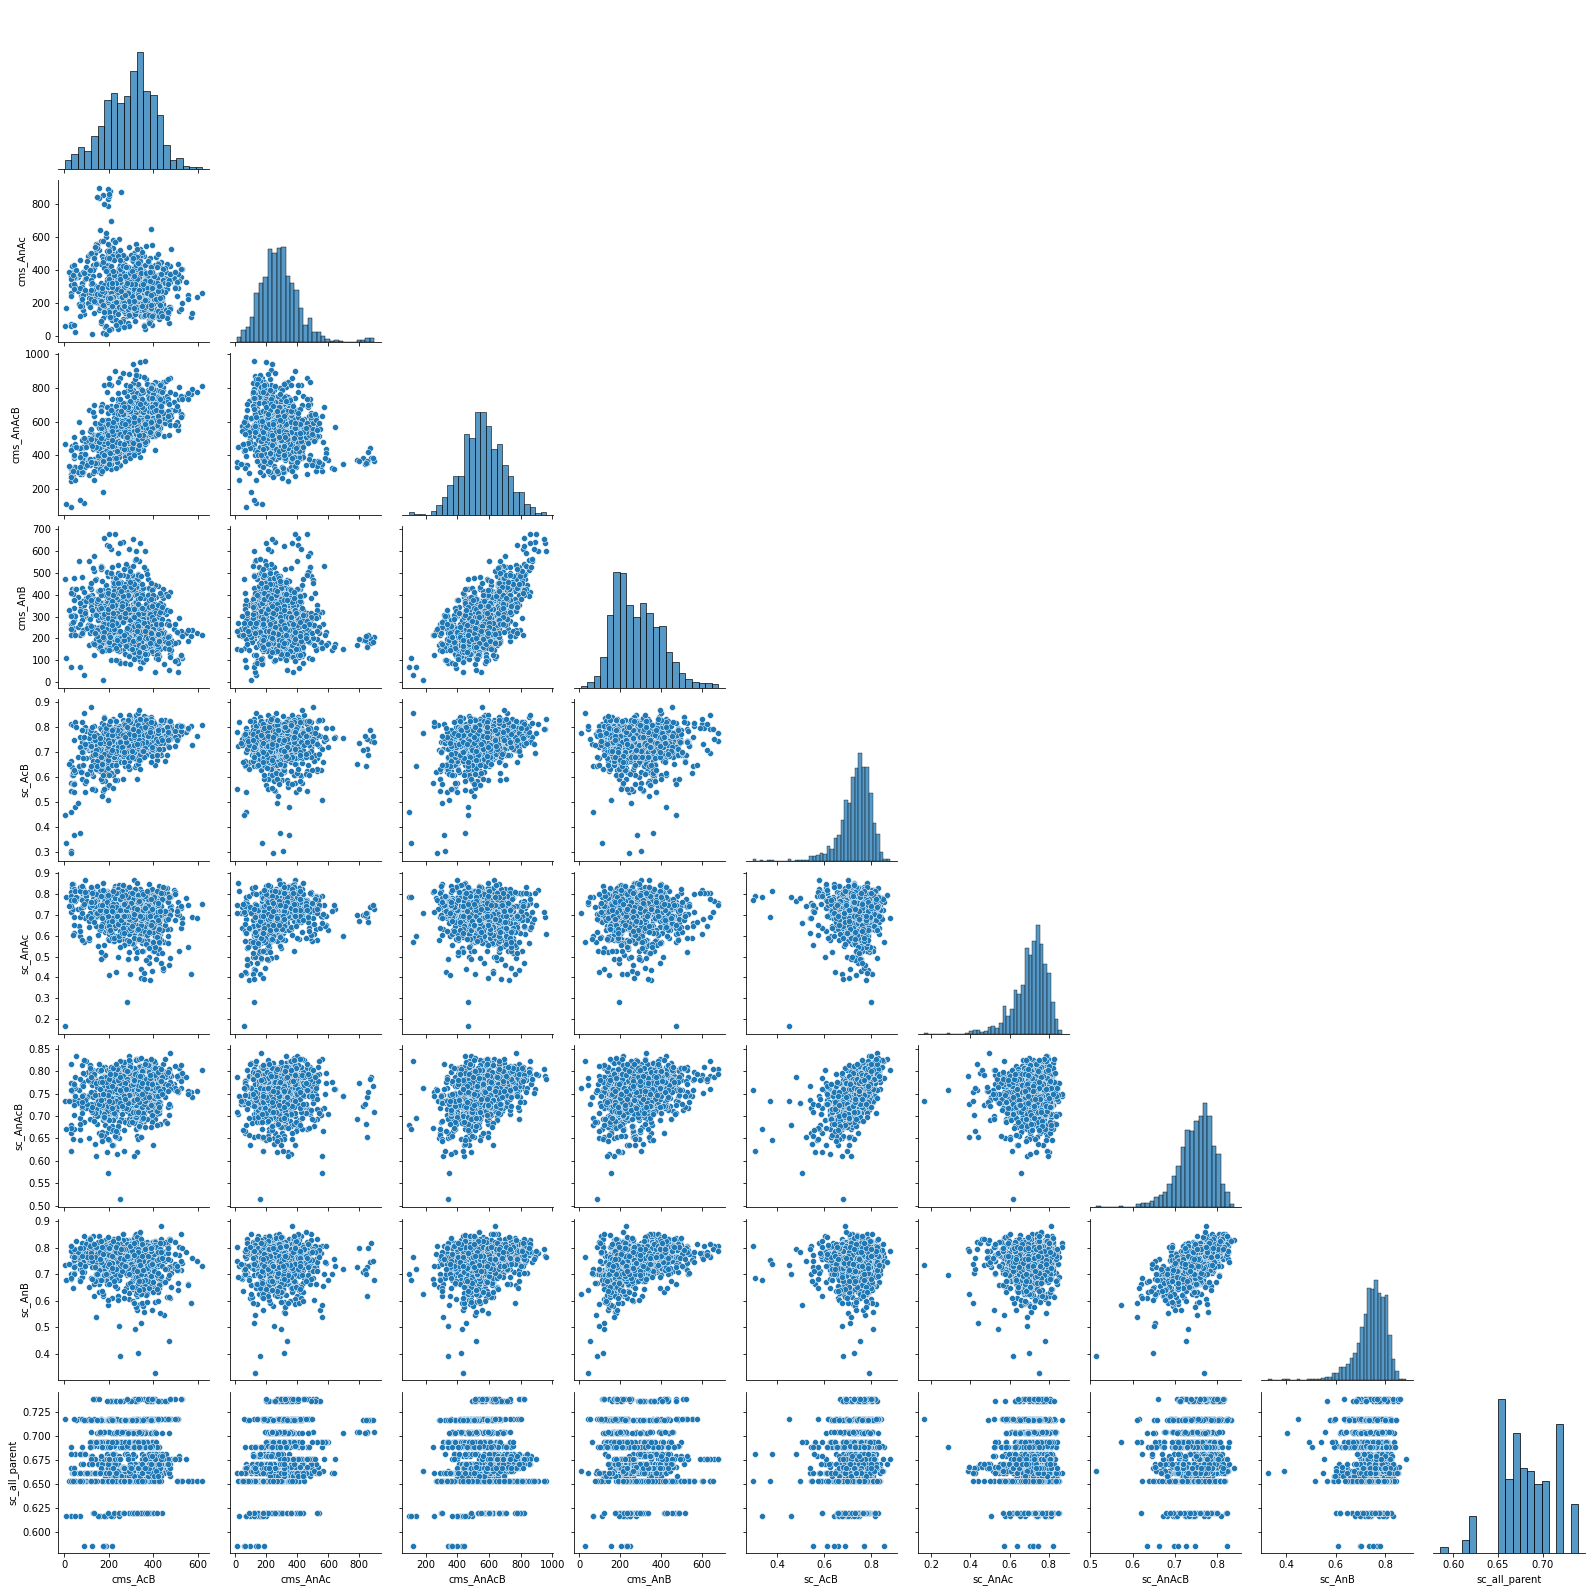

In [10]:
the_fig = pairplot_df(df=filt_df.sample(1000, random_state=0), cols=cols)
plt.savefig(os.path.join(output_path, "cms_and_sc_paired.png"))

### Filter the designed states leniently
We want to discard the obviously bad stuff here

In [12]:
cols = [col for col in scores_df.columns if "cms_" in col or "sc_" in col]
final_df = scores_df
for col in cols:
    if "sc_" in col:
        # worst sc_all_parent is 0.5833
        threshold = 0.58  # sc cutoff
    else:
        # these can have pretty small cross-sectional area
        threshold = 100  # cms cutoff
    final_df = final_df[final_df[col] > threshold]
print(len(final_df))

5429


### Save a list of outputs

In [13]:
simulation_name = "03_design_bound_states"
output_path = os.path.join("/home/broerman/crispy_shifty/projects/OPS/round_1/design", simulation_name)

with open(os.path.join(output_path, "designed_states.list"), "w") as f:
    for path in tqdm(final_df.index):
        print(path, file=f)

  0%|          | 0/5429 [00:00<?, ?it/s]